<a href="https://colab.research.google.com/github/kutluhanNG/MLcodes/blob/main/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
garymk_movielens_25m_dataset_path = kagglehub.dataset_download('garymk/movielens-25m-dataset')

print('Data source import complete.')


100%|██████████| 258M/258M [00:01<00:00, 168MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip install scikit-surprise
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy
import seaborn as sns
import matplotlib.pyplot as plt




In [4]:
tags = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "tags.csv"))
ratings = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "ratings.csv"))
movies = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "movies.csv"))
genome_scores = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "genome-scores.csv"))
genome_tags = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "genome-tags.csv"))
links = pd.read_csv(os.path.join(garymk_movielens_25m_dataset_path, "ml-25m", "links.csv"))

In [5]:
print(tags.shape)
print(ratings.shape)
print(movies.shape)
print(genome_scores.shape)
print(genome_tags.shape)
print(links.shape)

(1093360, 4)
(25000095, 4)
(62423, 3)
(15584448, 3)
(1128, 2)
(62423, 3)


In [6]:
dataframes = {
    'ratings': ratings,
    'tags': tags,
    'movies': movies,
    'genome_scores': genome_scores,
    'genome_tags': genome_tags,
    'links': links
}

for name, df in dataframes.items():
    print(f"Missing values in {name}:")
    print(df.isna().sum())
    print("-" * 30)


Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
------------------------------
Missing values in tags:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
------------------------------
Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64
------------------------------
Missing values in genome_scores:
movieId      0
tagId        0
relevance    0
dtype: int64
------------------------------
Missing values in genome_tags:
tagId    0
tag      0
dtype: int64
------------------------------
Missing values in links:
movieId      0
imdbId       0
tmdbId     107
dtype: int64
------------------------------


1. Handling Missing Values

In [7]:
tags = tags.dropna(subset=['tag'])
links = links.dropna(subset=['tmdbId'])


2. Exploring Distributions

<ipython-input-10-eb214e79421d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


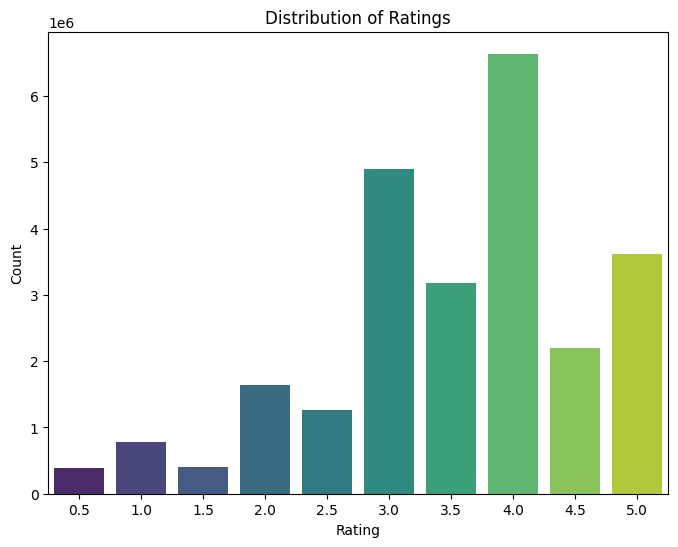

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

<ipython-input-11-5b0979e7ddb5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.index, y=top_tags.values, palette='viridis')


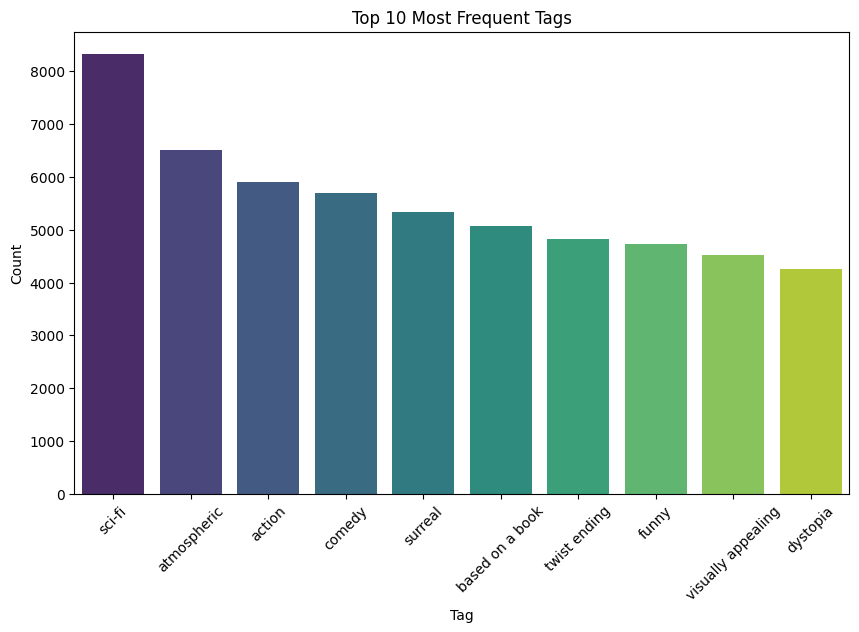

In [11]:
tags = tags.dropna(subset=['tag'])

# Get the top 10 most frequent tags
top_tags = tags['tag'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.index, y=top_tags.values, palette='viridis')
plt.title("Top 10 Most Frequent Tags")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


<ipython-input-12-cc0bd054937f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


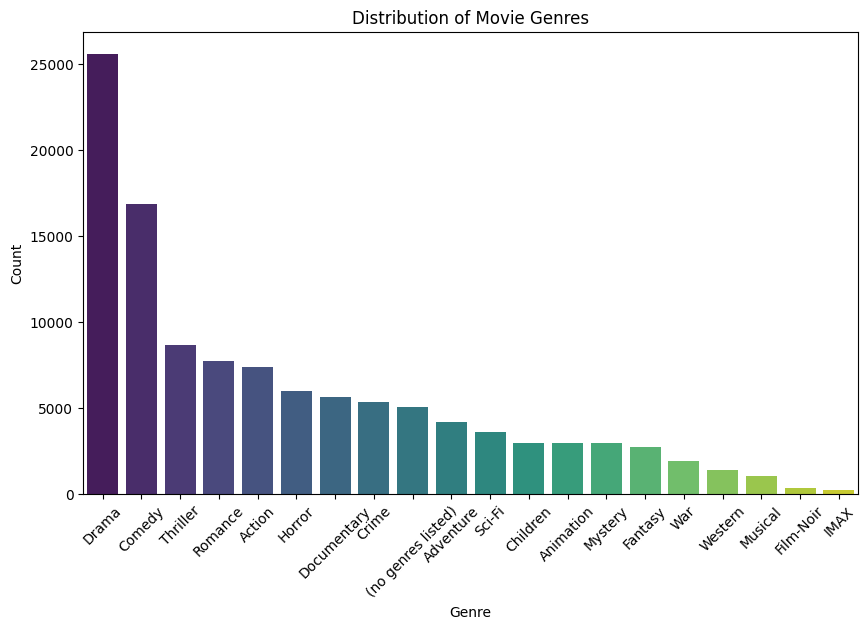

In [12]:
# Split the genres and explode the list into rows
genres_series = movies['genres'].str.split('|').explode()

# Count the occurrences of each genre
genre_counts = genres_series.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


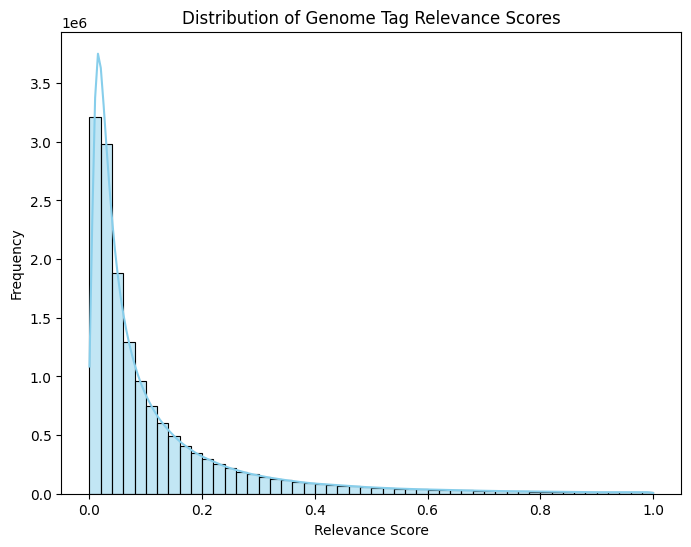

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(genome_scores['relevance'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Genome Tag Relevance Scores")
plt.xlabel("Relevance Score")
plt.ylabel("Frequency")
plt.show()


3. Prepare Data for Surprise

In [14]:
# Define the rating scale. For MovieLens, the scale is typically 0.5 to 5.0.
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset from our DataFrame
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [15]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [16]:
algo = SVD()
algo.fit(trainset)


In [17]:
predictions = algo.test(testset)


In [ ]:
# 5-fold cross-validation
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions."""
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)


In [ ]:
# Create a dictionary mapping movieId -> title
movie_dict = movies.set_index('movieId')['title'].to_dict()

# Print the top-10 movies recommended for a few sample users
for uid, user_ratings in list(top_n.items())[:5]:  # just show first 5 users
    recommended_titles = [movie_dict[movie_id] for (movie_id, _) in user_ratings]
    print(f"User {uid}: {recommended_titles}")
